# Практическая работа №4: Частотный анализ формул численного интегрирования

Выполнили студенты гр. 0303 Смирнов Артем и Переверза Михаил. Вариант №2.

## Цель работы

Провести анализ частотных характеристик известных формул численного интегрирования.

## Основные теоретические положения

**Дискретный фильтр** представляет собой ту или иную систему обработки дискретного сигнала, обладающую следующими свойствами: линейность, стационарность и наличие "памяти".

Пусть последовательность $\{x_k\}$ задает дискретный сигнал. Считаем, что $T$ - шаг дискретизации равен единице.

Обозначим выходной сигнал через $\{y_k\}$.

Дискретный фильтр может быть задан в виде:

$$y_k = b_0x_k + b_1x_{k-1} + ... + b_nx_{k-n} - a_1y_{k-1} + a_2y_{k-2} + ... + a_my_{k-m}$$

Если все $a_k = 0$ получим нерекурсивный фильтр, в ином случае - **рекурсивный**. Ограничений на соотношение чисел $n$ и $m$ нет.

**Формула прямоугольников:**

$$y_{n+1} = y_n + s_{n + \frac 1 2}, y_0 = 0, s_n = e^{i \omega n}$$

**Формула трапеций:**

$$y_{n+1} = y_n + \frac 1 2(s_n + s_{n+1}), y_0 = 0$$


**Формула Симпсона:**

$$y_{n+1} = y_{n-1} + \frac 1 3 (s_{n-1} + 4s_n + s_{n+1}),y_0 = 0$$


Передаточная функция $H(\omega)$ - периодическая функция с периодом $2\pi$. Частота рассматриваемого дискретного сигнала не должна превышать $\pi$, поэтому обычно рассматривается интервал $(-\pi, \pi)$ для круговой частоты $\omega$, или $(-0.5,0.5)$ для циклической частоты $f$:

$$H(\omega)=H(2\pi f)=\tilde H(f)$$

## Постановка задачи

Получить формулы для передаточных функций нерекурсивных фильтров, соответствующих полиномиальному сглаживанию дискретного сигнала для различных квадратурных формул и построить графики $\tilde {H}(f)$. Проинтерпретировать частотные свойства передаточных функций. Получить формулы для передаточных функций рекурсивных фильтров, соответствующих квадратурным формулам Ньютона-Котеса различного порядка. Проинтерпретировать частотные свойства передаточных функций. Провести сопоставительный анализ частотных характеристик передаточных функций для различных квадратурных формул.

## Выполнение работы

Импортируем необходимые библиотеки:

In [5]:
# установка зависимости, которая дает StrEnum на 3.10 версии Python
!pip install StrEnum

In [6]:
# импорт зависимостей

from collections.abc import Callable, Iterable, Sequence
from dataclasses import dataclass, field
from functools import partial
from typing import Any
from strenum import StrEnum

import matplotlib.pyplot as plt
import numpy as np

Определим функцию для отрисовки графиков:

In [7]:
@dataclass
class Range:
    start: float
    """Начало промежутка"""
    stop: float
    """Конец промежутка"""


@dataclass
class Graphic:
    """Конкретный график"""

    plot_function: Callable
    """Функция отрисовки"""
    y_function: Callable
    """Функция генерации y от x"""
    label: str = ''
    """label для графика"""
    x: Sequence | None = None
    """x для конкретного графика"""
    plot_kwargs: dict[str, Any] = field(default_factory=dict)
    """kwargs для передачи в функцию отрисовки"""

    def plot(self, x: Sequence, color: str, **kwargs):
        """Отрисовка конкретного графика"""

        x = self.x if self.x is not None else x
        y = self.y_function(x)

        # Выбор названия кварга, отвечающего за цвет графика
        # оно меняется, в зависимости от функции отрисовки в pyplot
        match self.plot_function:
            case plt.stem:
                color_arg = 'linefmt'
            case _:
                color_arg = 'color'

        kwargs.update({color_arg: color})
        kwargs.update(self.plot_kwargs)
        self.plot_function(x, y, label=self.label, **kwargs)


@dataclass
class GraphicsBlock:
    """Блок графиков, отображаемый на одной плитке"""

    graphics: list[Graphic]
    """Отображаемые блоки"""
    x: Sequence | None = None
    """x для блока графиков"""
    title: str = ''
    """title блока"""
    x_label: str = ''
    """Подпись к графику по x"""
    y_label: str = ''
    """Подпись к графику по x"""
    x_lim: Range | None = None
    """Ограничение графика по x"""
    y_lim: Range | None = None
    """Ограничение графика по y"""


def print_graphic(graphic_blocs: Iterable[GraphicsBlock]):
    """Отображение нескольких блоков графиков"""

    plt.figure(figsize=(20, 10))
    colors = ['blue', 'red', 'green', 'pink', 'orange']

    # перебор "прилиток" графиков
    block: GraphicsBlock
    color_index = 0
    for i, block in enumerate(graphic_blocs, start=1):
        plt.subplot(len(graphic_blocs), 1, i)

        # установка ограничений по осям
        if block.x_lim:
            plt.xlim(block.x_lim.start, block.x_lim.stop)
        if block.y_lim:
            plt.ylim(block.y_lim.start, block.y_lim.stop)

        # перебор конкретных графиов в плитке
        graphic: Graphic
        for j, graphic in enumerate(block.graphics):
            graphic.plot(x=block.x, color=colors[color_index])
            color_index += 1

        # задание оформления блоку
        plt.legend()
        plt.xlabel(block.x_label)
        plt.ylabel(block.y_label)
        plt.title(block.title)
        plt.grid()
    plt.show()

### Задание 1. Вывод формул передаточных функций рекурсивных фильтров, соответствующих квадратурным формулам прямоугольников, трапеций и Симпсона.

Пусть $s_n = e^{i \omega n}$,  $y_n = H(\omega)e^{i \omega n}$.

Точное значение интеграла $e^{i \omega t}$ равно $\frac {e^{i \omega t}} {i \omega}$.

Получим формулы передаточных функций рекурсивных фильтров, соответствующих квадратурным формулам прямоугольников, трапеций и Симпсона, а также отношения вычисляемого в результате фильтрации значения к истинному.

**Для формулы прямоугольников:**

$$y_{n+1} = y_n + s_{n + \frac 1 2}, y_0 = 0, s_n = e^{i \omega n}$$

Получаем: $H(\omega) = \frac {1}{1 - e^{-i\omega}} = \frac 1 {2i \sin {(\frac \omega 2)}}$, $\tilde {H}(f) = \frac 1 {2i \sin {(\pi f)}}$

Отношение значений: $\gamma = \frac {\text {Вычисленное}}{\text {Точное}} = \frac {(\frac \omega 2)}{\sin {(\frac \omega 2)}}$

**Для формулы трапеций:**

$$y_{n+1} = y_n + \frac 1 2(s_n + s_{n+1}), y_0 = 0$$

Получаем: $H(\omega) =  \frac {(e^{i \omega} + 1)}{2(e^{i \omega} - 1)} = \frac {\cos {(\frac \omega 2)}}{2i \sin {(\frac \omega 2)}}$, $\tilde {H}(f) = \frac {\cos {(\pi f)}}{2i \sin {(\pi f)}}$

Отношение значений: $\gamma = \frac {\text {Вычисленное}}{\text {Точное}} = \cos (\frac \omega 2) \frac {(\frac \omega 2)}{\sin (\frac \omega 2)} = 1 - \frac {\omega^2}{12} + \frac {\omega^4}{720} + \cdots$

**Для формулы Симпсона:**

$$y_{n+1} = y_{n-1} + \frac 1 3 (s_{n-1} + 4s_n + s_{n+1}),y_0 = 0$$

Получаем: $H(\omega) =  \frac {(e^{i \omega} + 4 + e^{-i \omega})}{3(e^{i \omega} - e^{-i \omega})} = \frac {\cos {(\omega)} + 2}{3i \sin {(\omega)}}$, $\tilde {H}(f) = \frac {\cos {(2 \pi f)} + 2}{3i \sin {(2 \pi f)}}$

Отношение значений: $\gamma = \frac {\text {Вычисленное}}{\text {Точное}} =  \frac {\cos {(\omega)} + 2} {3} \cdot \frac {\omega}{\sin {(\omega)}} = 1 + \frac {\omega^4}{180} + \cdots$

In [8]:
# Задание функций и констант для построения графиков

class BaseH(StrEnum):
    rectangle = 'rectangle'
    """Прямоугольник"""
    trapezoid = 'trapezoid'
    """Трапеция"""
    simpson = 'simpson'
    """Симпсон"""


h_mapper = {
    BaseH.rectangle: lambda x: (1 / (2j * np.sin(np.pi * x))).imag,
    BaseH.trapezoid: lambda x: (np.cos(np.pi * x) / (2j * np.sin(np.pi * x))).imag,
    BaseH.simpson: lambda x: ((np.cos(2 * np.pi * x) + 2) / (3j * np.sin(2 * np.pi * x))).imag,
}


gamma_mapper = {
    BaseH.rectangle: lambda x: (np.pi * x) / np.sin(np.pi * x),
    BaseH.trapezoid: lambda x: np.cos(np.pi * x) * (np.pi * x) / np.sin(np.pi * x),
    BaseH.simpson: lambda x: (2 * np.pi * x) * (np.cos(2 * np.pi * x) + 2) / (3 * np.sin(2 * np.pi * x)),
}


x_task_1 = np.linspace(0, 0.5, 2000)
x_task_1 = np.array([i for i in x_task_1 if i])

x_task_2 = np.linspace(0, 0.5, 2000)
x_task_2 = np.array([i for i in x_task_2 if i])

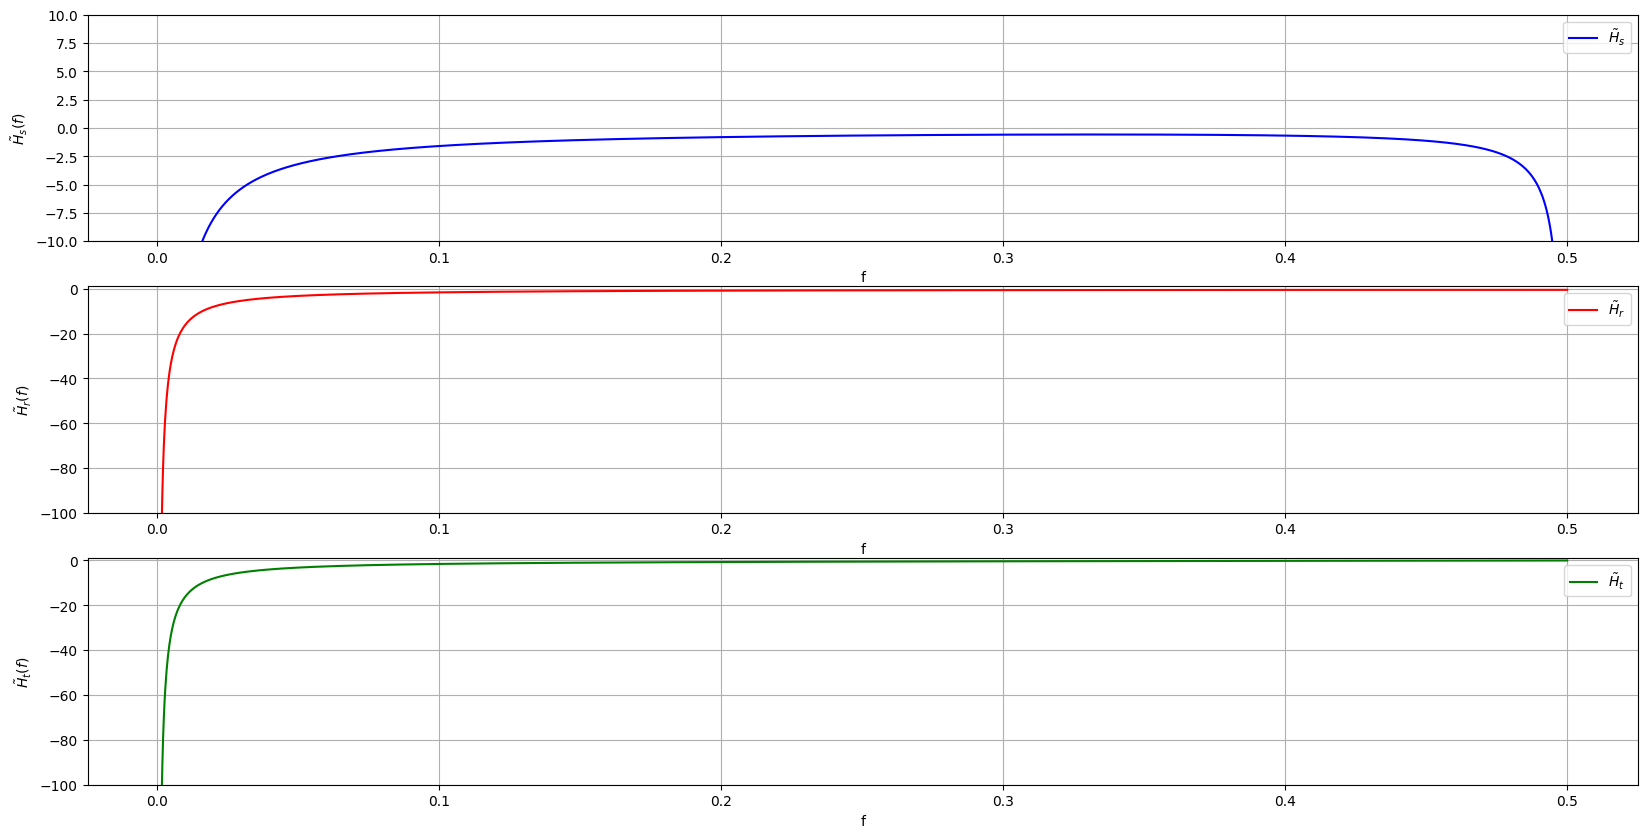

In [9]:
# отрисовка передаточных фукнций
# были внесены ограничения по оси Y, для наглядности графика


print_graphic(
    graphic_blocs=[
        GraphicsBlock(
            graphics=[
                Graphic(
                    plot_function=plt.plot,
                    x=x_task_1,
                    # H(w) для симпсона
                    y_function=h_mapper[BaseH.simpson],
                    label=r'$\tilde{H}_{s}$',
                ),
            ],
            x_label='f',
            y_label=r'$\tilde{H}_{s}(f)$',
            y_lim=Range(-10, 10),
        ),
        GraphicsBlock(
            graphics=[
                Graphic(
                    plot_function=plt.plot,
                    x=x_task_1,
                    # H(w) прямоугольника
                    y_function=h_mapper[BaseH.rectangle],
                    label=r'$\tilde{H}_{r}$',
                ),
            ],
            x_label='f',
            y_label=r'$\tilde{H}_{r}(f)$',
            y_lim=Range(-100, 1),
        ),
        GraphicsBlock(
            graphics=[
                Graphic(
                    plot_function=plt.plot,
                    x=x_task_1,
                    # H(w) для трапеции
                    y_function=h_mapper[BaseH.trapezoid],
                    label=r'$\tilde{H}_{t}$',
                ),
            ],
            x_label='f',
            y_label=r'$\tilde{H}_t(f)$',
            y_lim=Range(-100, 1),
        ),
    ],
)

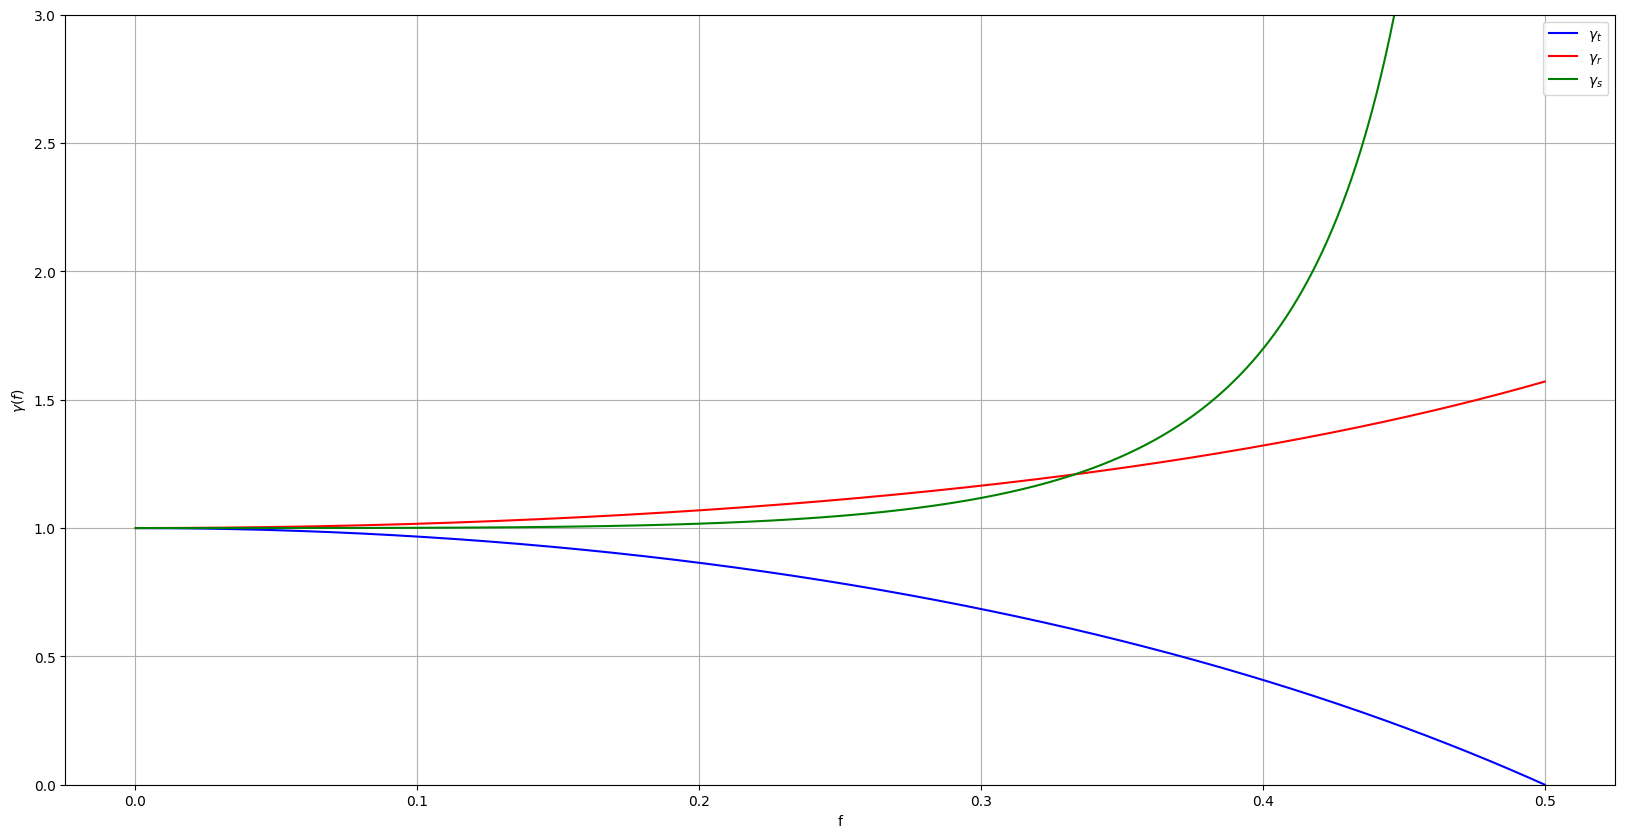

In [10]:
# отрисовка отношения вычисляемого в результате фильтрации значения к истинному
# по оси Y задано ограничение [0, 3] для наглядности графика

print_graphic(
    graphic_blocs=[
        GraphicsBlock(
            graphics=[
                Graphic(
                    plot_function=plt.plot,
                    x=x_task_2,
                    # y(w) для трапеции
                    y_function=gamma_mapper[BaseH.trapezoid],
                    label=r'$\gamma_{t}$',
                ),
                Graphic(
                    plot_function=plt.plot,
                    x=x_task_2,
                    # y(w) прямоугольника
                    y_function=gamma_mapper[BaseH.rectangle],
                    label=r'$\gamma_{r}$',
                ),
                Graphic(
                    plot_function=plt.plot,
                    x=x_task_2,
                    # y(w) для симпсона
                    y_function=gamma_mapper[BaseH.simpson],
                    label=r'$\gamma_{s}$',
                ),
            ],
            x_label='f',
            y_label=r'$\gamma(f)$',
            y_lim=Range(0, 3),
        ),
    ],
)

Из рисунка ясно, что при наличии шума (т.е. случайных высокочастотных компонентов), формула Симпсона более опасна, чем формула трапеций. Но когда в интегрируемой функции малы высокочастотные компоненты, то плоский характер передаточной функции делает формулу Симпсона более предпочтительной.

Можно сделать вывод о том, что если подинтегральная функция очень изменчивая, т.е. у нее много высоких частот, то, используя формулу Симпсона или прямоугольников, в выходном значении будет усилена роль этих высоких частот. В меньшей степени в этом случае влияние высоких частот сказывается на выходном результате численного интегрирования по формуле прямоугольников. При использовании формулы трапеций, наоборот, высокочастотные составляющие подавляются.

### Задание 2. Вывод формулы передаточной функции рекурсивного фильтра для интегрирования «по правилу 3/8».

$$y_{n+2} = y_{n-1} + \frac 1 8 (s_{n+2} + 3s_{n+1} + 3s_n + s_{n-1})$$

Пусть $s_n = e^{i \omega n}, y_n = H(\omega)e^{i \omega n}$.

Получаем: $H(\omega) = \frac {e^{2i \omega} + 3e^{i \omega} + 3 + e^{- i \omega}}{8 (e^{2 i \omega} - e^{- i \omega})} = \frac {\cos {(\frac {3\omega} 2)} + 3\cos{(\frac \omega 2)}}{8 i \sin (\frac {3\omega} 2)}$, $\tilde H (f) = \frac {\cos {(3 \pi f)} + 3 \cos{(\pi f)}}{8 i \sin (3 \pi f)}$

Точное значение интеграла $e^{i \omega t}$ равно $\frac {e^{i \omega t}} {i \omega}$.

Отношение значений: $\gamma = \frac {\text {Вычисленное}}{\text {Точное}} = \frac {(\cos {(\frac {3\omega} 2)} + 3 \cos{(\frac \omega 2)}) \omega}{8 \sin (\frac {3\omega} 2)}$


In [11]:
# Задание функций и констант для построения графиков

def h_func(x):
  return ((np.cos(3 * np.pi * x) + 3 * np.cos(np.pi * x)) / (8j * np.sin(3 * np.pi * x))).imag


def gamma_func(x):
  res = np.pi * x
  res = res * (np.cos(3 * np.pi * x) + 3 * np.cos(np.pi * x))
  res = res / (4 * np.sin(3 * np.pi * x))
  return res


x_task_3 = np.linspace(0, 0.5, 2000)
x_task_3 = np.array([i for i in x_task_3 if i])

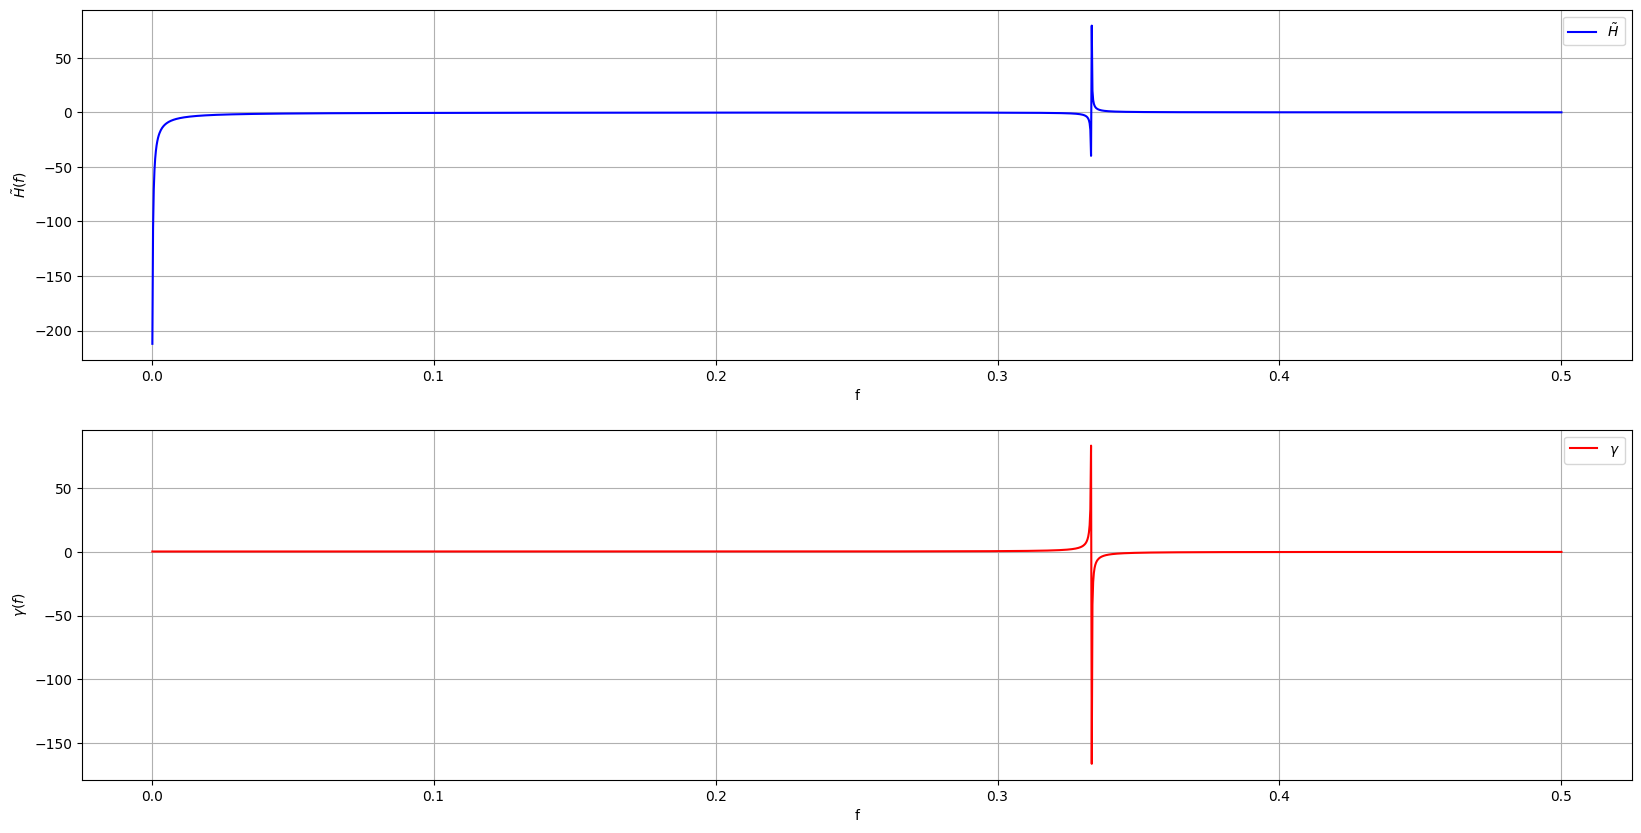

In [12]:
# отрисовка передаточных фукнций
# были внесены ограничения по оси Y, для наглядности графика


print_graphic(
    graphic_blocs=[
        GraphicsBlock(
            graphics=[
                Graphic(
                    plot_function=plt.plot,
                    x=x_task_3,
                    # H(w) для 3/8
                    y_function=h_func,
                    label=r'$\tilde{H}$',
                ),
            ],
            x_label='f',
            y_label=r'$\tilde{H}(f)$',
        ),
        GraphicsBlock(
            graphics=[
                Graphic(
                    plot_function=plt.plot,
                    x=x_task_3,
                    # y(w) для 3/8
                    y_function=gamma_func,
                    label=r'$\gamma$',
                ),
            ],
            x_label='f',
            y_label=r'$\gamma(f)$',
        ),
    ],
)

Появление скачка на графике передаточной функции обычно связано с наличием полюсов или нулей в передаточной функции, что влияет на поведение системы на различных частотах. На низких частотах амплитуда почти постоянна, что характерно для интегрирующего фильтра. Однако, вблизи скачка и в окрестности полюсов наблюдается значительное изменение амплитуды, что может привести к резким флуктуациям усиления.

Рекурсивный фильтр по «по правилу 3/8» обладает хорошей способностью усиления низких частот, но стоит учитывать, что вблизи скачка и полюсов амплитудно-частотная характеристика может проявлять резкие изменения, что может оказать влияние на его применение в конкретных задачах обработки сигналов.

### Задание 3. Сопоставительный анализ частотных характеристик передаточных функций, полученных при выполнении п. 1 и 2.

Можем сделать выводы о том, что:
1. Метод центральных прямоугольников обладает более выраженным усилением на низких частотах и менее выраженным подавлением на высоких частотах из-за своей особенности выбора центральной точки для интегрирования.
2. Метод трапеций обеспечивает менее выраженное усиление на низких частотах и более выраженное подавление на высоких частотах из-за учета двух точек при интегрировании.
3. Метод Симпсона обладает даже более выраженным подавлением на высоких частотах из-за более сложной формулы выбора точек при интегрировании.
4. Метод интегрирования по правилу 3/8 обеспечивает плавное и равномерное изменение усиления и имеет скачок на высоких частотах.

По сравнению друг с другом, можно сказать, что каждый метод обладает своими уникальными частотными характеристиками, которые обусловлены выбором точек для интегрирования. Прямоугольные правила обладают более сильным усилением на низких частотах, в то время как метод Симпсона и интегрирование по правилу 3/8 обеспечивают более плавное усиление и подавление на всем диапазоне частот.

## Выводы

В ходе выполнения практической работы были выведены формулы передаточных функций рекурсивных фильтров, соответствующих квадратурным формулам прямоугольников, трапеций и Симпсона, построены их графики и графики отношений вычисляемого в результате фильтрации значения к истинному.
Также была выведена формула передаточной функции рекурсивного фильтра для интегрирования «по правилу 3/8», построен ее график и график отношения вычисляемого в результате фильтрации значения к истинному.
Для полученных передаточных функций были проинтерпретированы их свойства и проведен сопоставительный анализ их частотных характеристик.
